# Business Understanding

Our MLB team wishes to improve upon our prior season's record in order to increase our chances of making a deep postseason run and winning the World Series next season.  Our offensive production was a weakness during the prior season.  We would like to use OPS to evaluate and predict the offensive production of MLB hitters.  OPS combines on-base skills (OBP or on-base percentage) with power hitting skills (slugging percentage), to measure overall offensive performace.  We will use this information to help build our roster for next season (evaluate our current under-contract players and possible trade acquisitions, as well as free agents).  Targeting hitters with a high OPS this offseason will help our team score more runs, win more games, perform better in the postseason, win a championship, and improve fan sentiment, driving revenue and profits in the process.

# Data Understanding

Our dataset is part of the Lahman Baseball database and obtained from Kaggle, compiled by author and journalist Sean Lahman.  It contains complete baseball statistics and data dating from 1871 to 2024.  We will use one   two of many tables, the "batting" table and the "people" table, for our purposes of evaluating and predicting offensive production.

## Data Preparation

The data contains plenty of records for modeling and includes all of the stats we need to compute our target, OPS. We have a few null values to deal with and we have a few irrelevant columns we can remove.

Certain columns contain null values because some of these stats were not tracked prior to certain dates. It makes sense to fill in zero for nulls in count-based stats. The oldest data is not going to factor heavily in our conclusions because we are looking for data relating to current players.

Our goal is to build a roster using OPS as a measure of offensive performance using current players, so using current data is important. Let's use 2000 as our cutoff year, as current players will have debuted by then and we still have a big enough dataset for robust modeling. We will also limit our data by defining a qualified hitter as a player with 125 or more at bats to avoid basing our conclusions on the smallest sample sizes.

After preparation, we will have 10,000+ records for robust modeling, they are modern era baseball records and contain many current players we can build our team around and/or target in trades or free agency!

In [5]:
# import necessary modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

In [6]:
# import modules to connect to Lahman Baseball Database on Kaggle
# code adapted from stackoverflow article here: https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab
# visit Kaggle.com and go to Settings under account, scroll to create new token, then input username and token into the below code to connect to data.

!pip install kaggle

import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"shannonhunley" ,
'key':"b7ebd96b78666b3cdf5a1824aa7c8d7d"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object 
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

OSError: [Errno 30] Read-only file system: '/root'

In [7]:
# downloading the Lahman baseball database which contains the hitting data

!kaggle datasets download -d dalyas/lahman-baseball-database

Dataset URL: https://www.kaggle.com/datasets/dalyas/lahman-baseball-database
License(s): CC-BY-SA-3.0
lahman-baseball-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# unzip the data

!unzip -o lahman-baseball-database.zip

Archive:  lahman-baseball-database.zip
  inflating: lahman_1871-2024_csv/AllstarFull.csv  
  inflating: lahman_1871-2024_csv/Appearances.csv  
  inflating: lahman_1871-2024_csv/AwardsManagers.csv  
  inflating: lahman_1871-2024_csv/AwardsPlayers.csv  
  inflating: lahman_1871-2024_csv/AwardsShareManagers.csv  
  inflating: lahman_1871-2024_csv/AwardsSharePlayers.csv  
  inflating: lahman_1871-2024_csv/Batting.csv  
  inflating: lahman_1871-2024_csv/BattingPost.csv  
  inflating: lahman_1871-2024_csv/CollegePlaying.csv  
  inflating: lahman_1871-2024_csv/Fielding.csv  
  inflating: lahman_1871-2024_csv/FieldingOF.csv  
  inflating: lahman_1871-2024_csv/FieldingOFsplit.csv  
  inflating: lahman_1871-2024_csv/FieldingPost.csv  
  inflating: lahman_1871-2024_csv/HallOfFame.csv  
  inflating: lahman_1871-2024_csv/HomeGames.csv  
  inflating: lahman_1871-2024_csv/Managers.csv  
  inflating: lahman_1871-2024_csv/ManagersHalf.csv  
  inflating: lahman_1871-2024_csv/Parks.csv  
  inflating: lah

In [45]:
# reading in the data, getting a look at its columns and some values
df = pd.read_csv('lahman_1871-2024_csv/Batting.csv')

df.head()

,playerID,yearID,stint,teamID,lgID,G,G_batting,AB,R,H,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,G_old
0,aardsda01,2004,1,SFN,NL,11,NaN,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,aardsda01,2006,1,CHN,NL,45,NaN,2,0,0,...,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
2,aardsda01,2007,1,CHA,AL,25,NaN,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,aardsda01,2008,1,BOS,AL,47,NaN,1,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
4,aardsda01,2009,1,SEA,AL,73,NaN,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [46]:
# looking at the amount of data and columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115450 entries, 0 to 115449
Data columns (total 24 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   playerID   115450 non-null  object 
 1   yearID     115450 non-null  int64  
 2   stint      115450 non-null  int64  
 3   teamID     115450 non-null  object 
 4   lgID       114713 non-null  object 
 5   G          115450 non-null  int64  
 6   G_batting  3266 non-null    float64
 7   AB         115450 non-null  int64  
 8   R          115450 non-null  int64  
 9   H          115450 non-null  int64  
 10  2B         115450 non-null  int64  
 11  3B         115450 non-null  int64  
 12  HR         115450 non-null  int64  
 13  RBI        114694 non-null  float64
 14  SB         113082 non-null  float64
 15  CS         91908 non-null   float64
 16  BB         115450 non-null  int64  
 17  SO         113350 non-null  float64
 18  IBB        78799 non-null   float64
 19  HBP        112634 non-n

In [47]:
# looking at the values of column 'G_old' since I'm unfamiliar with it, to see what info it provides

df['G_old'].value_counts()

0.0    1651
Name: G_old, dtype: int64

In [48]:
# dropping unnecessary columns

df_clean = df.drop(columns=['stint', 'teamID', 'lgID', 'G', 'G_batting', 'SB', 'CS', 'GIDP', 'G_old'])
df_clean.head()

,playerID,yearID,AB,R,H,2B,3B,HR,RBI,BB,SO,IBB,HBP,SH,SF
0,aardsda01,2004,0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
1,aardsda01,2006,2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,1.0,0.0
2,aardsda01,2007,0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
3,aardsda01,2008,1,0,0,0,0,0,0.0,0,1.0,0.0,0.0,0.0,0.0
4,aardsda01,2009,0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [49]:
# confirming uneeded columns dropped and looking into null values

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115450 entries, 0 to 115449
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   playerID  115450 non-null  object 
 1   yearID    115450 non-null  int64  
 2   AB        115450 non-null  int64  
 3   R         115450 non-null  int64  
 4   H         115450 non-null  int64  
 5   2B        115450 non-null  int64  
 6   3B        115450 non-null  int64  
 7   HR        115450 non-null  int64  
 8   RBI       114694 non-null  float64
 9   BB        115450 non-null  int64  
 10  SO        113350 non-null  float64
 11  IBB       78799 non-null   float64
 12  HBP       112634 non-null  float64
 13  SH        109382 non-null  float64
 14  SF        79346 non-null   float64
dtypes: float64(6), int64(8), object(1)
memory usage: 13.2+ MB


In [50]:
# look at values for one of the columns containing null values

df_clean['RBI'].value_counts()

0.0      42801
1.0       7611
2.0       5396
3.0       3923
4.0       3286
         ...  
166.0        1
184.0        1
167.0        1
174.0        1
171.0        1
Name: RBI, Length: 175, dtype: int64

In [51]:
# look at total nulls per column by number and percentage

print(df_clean.isnull().sum())

print((df_clean.isnull().sum() / len(df_clean)) * 100)

# look at some nulls in particular columns

df_clean[df_clean['HBP'].isnull()].head()

playerID        0
yearID          0
AB              0
R               0
H               0
2B              0
3B              0
HR              0
RBI           756
BB              0
SO           2100
IBB         36651
HBP          2816
SH           6068
SF          36104
dtype: int64
playerID     0.000000
yearID       0.000000
AB           0.000000
R            0.000000
H            0.000000
2B           0.000000
3B           0.000000
HR           0.000000
RBI          0.654829
BB           0.000000
SO           1.818969
IBB         31.746210
HBP          2.439151
SH           5.255955
SF          31.272412
dtype: float64


,playerID,yearID,AB,R,H,2B,3B,HR,RBI,BB,SO,IBB,HBP,SH,SF
67,abadijo01,1875,4,1,1,0,0,0,1.0,0,0.0,NaN,NaN,NaN,NaN
68,abadijo01,1875,45,3,10,0,0,0,4.0,0,3.0,NaN,NaN,NaN,NaN
162,abercda01,1871,4,0,0,0,0,0,0.0,0,0.0,NaN,NaN,NaN,NaN
500,adamsge01,1879,13,0,3,0,0,0,0.0,1,1.0,NaN,NaN,NaN,NaN
645,addybo01,1871,118,30,32,6,0,0,13.0,4,0.0,NaN,NaN,NaN,NaN


In [52]:
# filling null values with 0

count_cols = ['RBI', 'SO', 'IBB', 'HBP', 'SH', 'SF']
df_clean[count_cols] = df_clean[count_cols].fillna(0)

In [53]:
# filter for modern baseball era
df_clean = df_clean[df_clean['yearID'] >= 2000]

# filter for qualified hitters
df_clean = df_clean[df_clean['AB'] >= 125]

print(df_clean.shape)

(10119, 15)


In [54]:
# confirm the dataset size, columns, and that null values are removed
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10119 entries, 114 to 115413
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  10119 non-null  object 
 1   yearID    10119 non-null  int64  
 2   AB        10119 non-null  int64  
 3   R         10119 non-null  int64  
 4   H         10119 non-null  int64  
 5   2B        10119 non-null  int64  
 6   3B        10119 non-null  int64  
 7   HR        10119 non-null  int64  
 8   RBI       10119 non-null  float64
 9   BB        10119 non-null  int64  
 10  SO        10119 non-null  float64
 11  IBB       10119 non-null  float64
 12  HBP       10119 non-null  float64
 13  SH        10119 non-null  float64
 14  SF        10119 non-null  float64
dtypes: float64(6), int64(8), object(1)
memory usage: 1.2+ MB


# Exploratory Data Analysis

Now we can calculate our target (OPS) and explore its relationship(s), if any, to our other data!  OPS is calculated as follows:
OPS = OBP + SLG
OBP is on-base percentage which measures how often a player gets on base (hits, walks, and hit by pitch).
SLG is slugging percentage, which measures a hitter's power by dividing total bases by total at-bats.

In [55]:
# define functions for feature calculations

def calculate_obp(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate On-Base Percentage (OBP) with division-by-zero handling."""
    numerator = df['H'] + df['BB'] + df['HBP']
    denominator = df['AB'] + df['BB'] + df['HBP'] + df['SF']
    df['OBP'] = np.where(denominator != 0, numerator / denominator, 0)  # Use np.where for vectorized handling
    return df
    
def calculate_tb(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate Total Bases (TB)."""
    df['TB'] = (
        (df['H'] - df['2B'] - df['3B'] - df['HR']) +  # Singles
        (2 * df['2B']) + (3 * df['3B']) + (4 * df['HR'])
    )
    return df
    
def calculate_slg(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate Slugging Percentage (SLG) with division-by-zero handling."""
    denominator = df['AB']
    df['SLG'] = np.where(denominator != 0, df['TB'] / denominator, 0)
    return df
    
def calculate_ops(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate On-base Plus Slugging (OPS), filling any NaNs with 0."""
    df['OPS'] = df['OBP'] + df['SLG']
    df['OPS'] = df['OPS'].fillna(0)
    return df

In [56]:
# feature engineer OPS and its components

df_clean = (
    df_clean.pipe(calculate_obp)
            .pipe(calculate_tb)
            .pipe(calculate_slg)
            .pipe(calculate_ops)
)

In [57]:
# feature-engineering our target variable, OPS, and its components

# calculate OBP or on-base percentage, avoid throwing data with division by zero
numerator_obp = df_clean['H'] + df_clean['BB'] + df_clean['HBP']
denominator_obp = df_clean['AB'] + df_clean['BB'] + df_clean['HBP'] + df_clean['SF']
denominator_obp = denominator_obp.replace(0, np.nan) # avoid division by zero
df_clean['OBP'] = numerator_obp / denominator_obp

# calculate total bases
df_clean['TB'] = (df_clean['H'] - df_clean['2B'] - df_clean['3B'] - df_clean['HR']) + (2 * df_clean['2B']) + (3 * df_clean['3B']) + (4 * df_clean['HR'])

# calculate slugging percentage, avoid throwing data by dividing by zero
df_clean['SLG'] = df_clean['TB'] / df_clean['AB'].replace(0, np.nan) # avoid division by zero

# calculate OPS
df_clean['OPS'] = df_clean['OBP'] + df_clean['SLG']
df_clean['OPS'] = df_clean['OPS'].fillna(0)

In [58]:
# preview target
print(df_clean[['playerID', 'yearID', 'OPS']].head(60))

      playerID  yearID       OPS
114  abbotje01    2000  0.738445
135  abbotku01    2000  0.671772
163  abercre01    2006  0.604091
167  abernbr01    2001  0.709892
168  abernbr01    2002  0.599322
217  abramcj01    2022  0.604672
218  abramcj01    2022  0.603118
219  abramcj01    2023  0.711587
220  abramcj01    2024  0.747008
233  abreubo01    2000  0.969996
234  abreubo01    2001  0.935983
235  abreubo01    2002  0.934118
236  abreubo01    2003  0.876571
237  abreubo01    2004  0.971324
238  abreubo01    2005  0.879219
239  abreubo01    2006  0.925876
240  abreubo01    2006  0.860569
241  abreubo01    2007  0.813727
242  abreubo01    2008  0.842609
243  abreubo01    2009  0.824974
244  abreubo01    2010  0.786879
245  abreubo01    2011  0.717282
247  abreubo01    2012  0.704459
248  abreubo01    2014  0.680281
256  abreujo02    2014  0.963572
257  abreujo02    2015  0.849752
258  abreujo02    2016  0.820467
259  abreujo02    2017  0.906409
260  abreujo02    2018  0.798443
261  abreu

Acuna showing most seasons with an .800+ OPS looks about right!  These values make sense, so we can feel confident in our calculations.  Now we're going to drop the variable columns containing raw stats which which feed into the calculation of OPS to avoid multicollinearity, because we already know those relationships exist.  We keep other features like R, RBI, SO, and more for modeling.

In [59]:
# identify redundant columns
ops_component_cols = ['AB', 'H', '2B', '3B', 'HR', 'BB', 'HBP', 'SF', 'TB', 'OBP', 'SLG']

# drop redundant columns
df_clean = df_clean.drop(columns=ops_component_cols, errors='ignore')

# preview remaining data
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10119 entries, 114 to 115413
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  10119 non-null  object 
 1   yearID    10119 non-null  int64  
 2   R         10119 non-null  int64  
 3   RBI       10119 non-null  float64
 4   SO        10119 non-null  float64
 5   IBB       10119 non-null  float64
 6   SH        10119 non-null  float64
 7   OPS       10119 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 711.5+ KB


Let's investigate some relationships between OPS and other remaining data.  Age is an important variable not contained in our data, so let's add that in from another CSV contained in the Lahman baseball database (People).  'PlayerID' is also not very clear, so we can use this CSV later for player names as well.

In [60]:
# read in People.csv
people = pd.read_csv('lahman_1871-2024_csv/People.csv')

#calculate age
people['birthYear'] = people['birthYear'].fillna(0).astype(int)
df_clean = pd.merge(df_clean, people[['playerID', 'birthYear']], on='playerID', how='left')
df_clean['age'] = df_clean['yearID'] - df_clean['birthYear']
df_clean['age'] = df_clean['age'].clip(18, 50) # clip outliers

# drop birth year since we have age now
df_clean = df_clean.drop(columns=['birthYear'], errors='ignore')

# preview data containing age
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10119 entries, 0 to 10118
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  10119 non-null  object 
 1   yearID    10119 non-null  int64  
 2   R         10119 non-null  int64  
 3   RBI       10119 non-null  float64
 4   SO        10119 non-null  float64
 5   IBB       10119 non-null  float64
 6   SH        10119 non-null  float64
 7   OPS       10119 non-null  float64
 8   age       10119 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 790.5+ KB


In [61]:
# define OPS_next as our target for prediction, sort for ease of interpretation

df_clean = df_clean.sort_values(['playerID', 'yearID'])
df_clean["OPS_next"] = df_clean.groupby('playerID')['OPS'].shift(-1)

df_train = df_clean[df_clean['yearID'] < 2024].dropna(subset=['OPS_next'])

<function matplotlib.pyplot.show(close=None, block=None)>

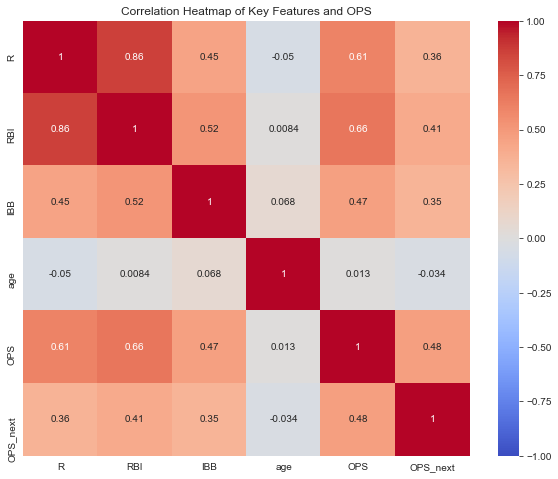

In [62]:
# correlation matrix of features

sns.set_style('whitegrid')

numeric_cols = ['R', 'RBI', 'IBB', 'age', 'OPS', 'OPS_next']
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Features and OPS')

plt.savefig('correlation.png')
plt.show

We can see a notable lack of relationship between age and the other stats above, so let's investigate that further.

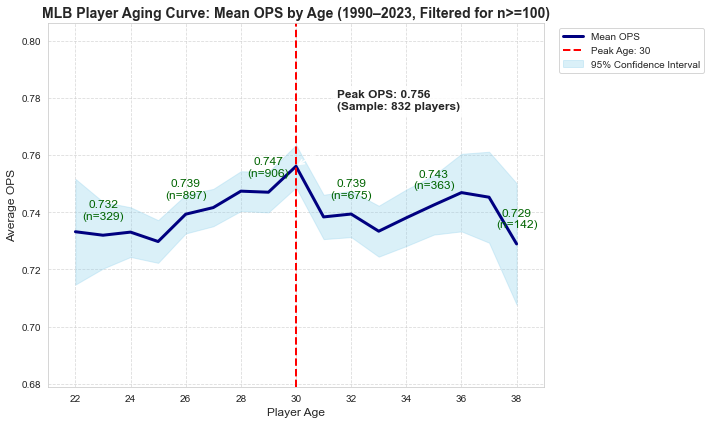

In [63]:
# plot age vs. OPS

sns.set_style('whitegrid')
sns.set_palette('deep')

# calculate age stats: mean, SEM for CI
age_stats = df_clean.groupby('age')['OPS'].agg(['mean', 'sem', 'count']).reset_index()
age_stats['lower_ci'] = age_stats['mean'] - 1.96 * age_stats['sem']
age_stats['upper_ci'] = age_stats['mean'] + 1.96 * age_stats['sem']

# filter for reliable samples
age_stats = age_stats[age_stats['count'] >= 100]

age_stats = age_stats[(age_stats['age'] >= 22) & (age_stats['age'] <= 38)]

# create plot
plt.figure(figsize=(10, 6))

# mean line with shaded CI
plt.plot(age_stats['age'], age_stats['mean'], color='navy', lw=3, label='Mean OPS')
plt.fill_between(
    age_stats['age'], 
    age_stats['lower_ci'], 
    age_stats['upper_ci'], 
    color='skyblue', 
    alpha=0.3, 
    label='95% Confidence Interval'
)

# Highlight peak
peak_idx = age_stats['mean'].idxmax()
peak_age = age_stats.loc[peak_idx, 'age']
peak_ops = age_stats.loc[peak_idx, 'mean']
plt.axvline(x=peak_age, color='red', linestyle='--', lw=2, label=f'Peak Age: {int(peak_age)}')
plt.annotate(
    f'Peak OPS: {peak_ops:.3f}\n(Sample: {int(age_stats.loc[peak_idx, "count"])} players)', 
    xy=(peak_age, peak_ops), 
    xytext=(peak_age + 1.5, peak_ops + 0.02),
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
    fontsize=12,
    fontweight='bold',
    bbox=dict(facecolor='white', alpha=0.8)
)

# add labels for mean OPS and count at each point
for i, row in age_stats.iterrows():
    if i % 3 == 0:  # label every 3rd point
        plt.text(row['age'], row['mean'] + 0.005, f'{row["mean"]:.3f}\n(n={int(row["count"])})',
                 ha='center', va='bottom', fontsize=12, color='darkgreen')

# titles and labels
plt.title('MLB Player Aging Curve: Mean OPS by Age (1990–2023, Filtered for n>=100)', fontsize=14, fontweight='bold')
plt.xlabel('Player Age', fontsize=12)
plt.ylabel('Average OPS', fontsize=12)

# zoom based on data
plt.xlim(age_stats['age'].min() - 1, age_stats['age'].max() + 1)
plt.ylim(age_stats['mean'].min() - 0.05, age_stats['mean'].max() + 0.05)

# grid, legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()

# show plot and save image
plt.savefig('agingcurve.png')
plt.show()

# Modeling and Evaluation

We will begin with a baseline linear regression model and then try an XGBoost model.  We will create lag features to help better predict OPS as it exhibits strong year-to-year correlation and can improve our modeling.  Lag features are an important technique in time-series fofrecasting modeling and are especially useful in predicting player performace in sport analytics.

In [64]:
# checking data features

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10119 entries, 0 to 10118
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  10119 non-null  object 
 1   yearID    10119 non-null  int64  
 2   R         10119 non-null  int64  
 3   RBI       10119 non-null  float64
 4   SO        10119 non-null  float64
 5   IBB       10119 non-null  float64
 6   SH        10119 non-null  float64
 7   OPS       10119 non-null  float64
 8   age       10119 non-null  int64  
 9   OPS_next  8119 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.2+ MB


In [65]:
# create lag features
# code adapted from CodeSignal article https://codesignal.com/learn/courses/preparing-financial-data-for-machine-learning/lessons/creating-lag-features-for-time-series-prediction
# create lag features for prior-year OPS, two years prior OPS, and a weighted average to emphasize newer data
df_clean = df_clean.sort_values(['playerID', 'yearID'])
df_clean['OPS_lag1'] = df_clean.groupby('playerID')['OPS'].shift(1)  # prior year
df_clean['OPS_lag2'] = df_clean.groupby('playerID')['OPS'].shift(2)  # two years back
df_clean = df_clean.dropna(subset=['OPS_lag1', 'OPS_lag2'])

df_clean['OPS_weighted'] = (5 * df_clean['OPS'] + 4 * df_clean['OPS_lag1'] + 3 * df_clean['OPS_lag2']) / 12


In [66]:
# for recommendations, to predict 2025 on 2024 data
# prepare features
features = ['age', 'R', 'RBI', 'SO', 'IBB', 'SH', 'OPS', 'OPS_lag1', 'OPS_lag2', 'OPS_weighted']
df_2024 = df_clean[df_clean['yearID'] == 2024].copy()

X_2024 = df_2024[features]

X_2024 = X_2024.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='mean')
X_2024 = pd.DataFrame(imputer.fit_transform(X_2024), columns=X_2024.columns, index=X_2024.index)

In [67]:
# prepare features and target
X = df_clean[features]
y = df_clean['OPS_next']

# handle infs and nulls in X and y
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# drop rows with nulls in y (OPS_next nulls)
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask]
df_clean = df_clean[valid_mask]

# impute remaining nulls in X
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

train_mask = df_clean['yearID'] < 2023
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
print(f'Baseline Linear Regression MAE: {mae_baseline:.3f}')

Baseline Linear Regression MAE: 0.068


In [68]:
# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

# predict
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb:.3f}')

# calculate improvement
print(f'Improvement over baseline model: {(mae_baseline - mae_xgb) / mae_baseline * 100:.1f}%')

XGBoost MAE: 0.070
Improvement over baseline model: -2.5%


In [69]:
# define param grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# tune XGBoost with CV
xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                          cv=5, scoring='neg_mean_absolute_error',
                          verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# best model and params
best_xgb = grid_search.best_estimator_
print('Best Params:', grid_search.best_params_)

# evaluate on test
y_pred_best = best_xgb.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f'Tuned XGBoost MAE: {mae_best:.3f}')
print(f'Improvement over original: {(mae_xgb - mae_best) / mae_xgb * 100:.1f}%')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.5s


Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Tuned XGBoost MAE: 0.069
Improvement over original: 0.9%


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   24.4s finished


In [70]:
# try randomized search
# param dist
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': [1, 3, 5]  # prevent overfitting
}

# randomized search with CV
xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=50,  # Try 50-100 trials
                                   cv=5, scoring='neg_mean_absolute_error', 
                                   verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# best and evaluate
best_xgb = random_search.best_estimator_
print('Best Params:', random_search.best_params_)
y_pred_best = best_xgb.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f'Tuned XGBoost MAE: {mae_best:.3f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.7s


Best Params: {'colsample_bytree': 0.7801997007878172, 'learning_rate': 0.012652992231973307, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 291, 'subsample': 0.7541666010159664}
Tuned XGBoost MAE: 0.068


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   30.6s finished


In [71]:
# select features and preprocess
X_2024 = df_2024[features]

# handle nulls
X_2024 = X_2024.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='mean')
X_2024 = pd.DataFrame(imputer.fit_transform(X_2024), columns=X_2024.columns, index=X_2024.index)

# ensure columns match X_train
missing_cols = set(X_train.columns) - set(X_2024.columns)
for col in missing_cols:
    X_2024[col] = 0
X_2024 = X_2024[X_train.columns]  # reorder/drop extras

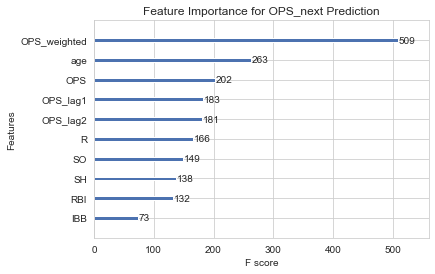

In [72]:
# plot feature importance
xgb.plot_importance(best_xgb)
plt.title('Feature Importance for OPS_next Prediction')

imputer = SimpleImputer(strategy='mean')
X_2024 = pd.DataFrame(imputer.fit_transform(X_2024), columns=X_2024.columns, index=X_2024.index)
plt.show()

In [73]:
# predict
df_2024['predicted_OPS_2025'] = best_xgb.predict(X_2024)
top_5 = df_2024.sort_values('predicted_OPS_2025', ascending=False).head(5)
print(top_5[['playerID', 'age', 'predicted_OPS_2025']])

# get names from the people table to improve interpretability      
top_5_named = pd.merge(top_5, people[['playerID', 'nameFirst', 'nameLast']], on='playerID', how='left')
top_5_named['name'] = top_5_named['nameFirst'] + ' ' + top_5_named['nameLast']
print(top_5_named[['name', 'age', 'predicted_OPS_2025']])

       playerID  age  predicted_OPS_2025
4874  judgeaa01   32            1.004522
6753  ohtansh01   30            0.924901
209   alvaryo01   27            0.912381
8717   sotoju01   26            0.908105
9273  tuckeky01   27            0.853336
             name  age  predicted_OPS_2025
0     Aaron Judge   32            1.004522
1   Shohei Ohtani   30            0.924901
2  Yordan Alvarez   27            0.912381
3       Juan Soto   26            0.908105
4     Kyle Tucker   27            0.853336


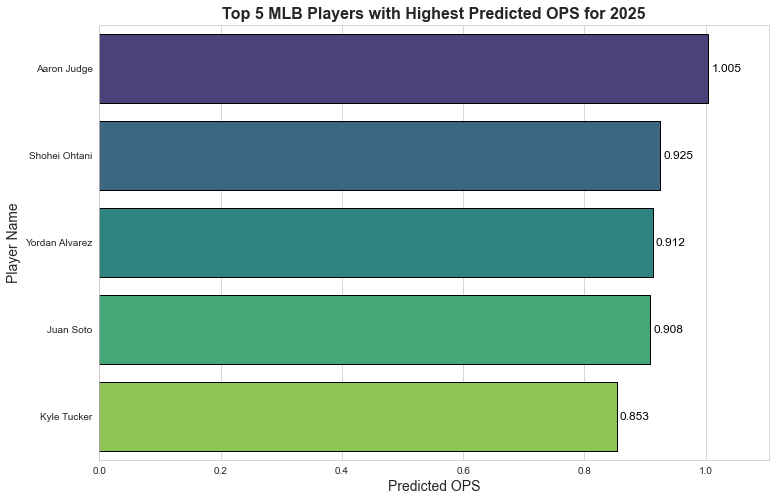

In [74]:
# sort by predicted 2025 OPS
top_5_named = top_5_named.sort_values('predicted_OPS_2025', ascending=False)

#set a clean, easy to see style
sns.set_style('whitegrid')

# create bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='predicted_OPS_2025',
    y='name',
    data=top_5_named,
    palette='viridis',
    edgecolor='black'
)

# add value labels on bars
for i, v in enumerate(top_5_named['predicted_OPS_2025']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=12, color='black')

# titles and labels
plt.title('Top 5 MLB Players with Highest Predicted OPS for 2025', fontsize=16, fontweight='bold')
plt.xlabel('Predicted OPS', fontsize=14)
plt.ylabel('Player Name', fontsize=14)

# show graph
plt.xlim(0, top_5_named['predicted_OPS_2025'].max() + 0.1)
plt.savefig('top 5 players')
plt.show()

# Conclusion

1) OPS is somewhat correlated with other offensive stats like RBI and runs, but the most glaring relationship is the inverse relationship with age.

2) OPS peaks around age 28-30 and declines thereafter.

3) Aaron Judge, Shohei Ohtani, Yordan Alvarez, Juan Soto and Kyle Tucker have are the top 5 players with the highest predicted OPS.

## Limitations

The Lahman Baseball Database contains player salary information, but it does not contain player contract details.  Acquiring the best players will typically involve a long, multi-year commitment.  Those details and the total contract implications for the team might factor heavily into the decision to acquire a player, so adding that information to the data would be helpful.

## Recommendations

1) Consider the totality of offensive stats when making decisions to persue a player, but know that age has an outsize impact on OPS.

2) Since OPS peaks around age 28-30, bear this in mind when offering or acquiring long player contracts.

3) We should prioritize acquiring Aaron Judge, Shohei Ohtani, Yordan Alvarez, Juan Soto, and/or Kyle Tucker when possible.  In reality, of these top 5, only Kyle Tucker is a free agent this offseason.  He should be our top offseason priority, since the others in the top 5 are locked into long-term contracts with their respective teams and would require an absolute haul to trade for in the unlikely event that a trade is even on the table.

## Next Steps

1) Find a way to work player contract data into our calculations so that can factor into our recommendations.  We may know these players contract situations off-hand as baseball nerds, but not everyone does.

2) We can work player salary data into the mix now since the Lahman Baseball Database contains salary information.  Even though it will not take into acocunt the long-term affect on the team and its finances moving forward, it can give is an idea of ROI on a year-to-year basis.